<a href="https://colab.research.google.com/github/MarcelodeFreitas/udemy_deep_learning_pytorch_python/blob/main/Projeto_1_Classifica%C3%A7%C3%A3o_bin%C3%A1ria_breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 1: Classificação binária brest cancer

## Etapa 1: Importação das bibliotecas

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
import torch
torch.__version__
!pip install torch==1.4.0

ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2)
ERROR: No matching distribution found for torch==1.4.0


In [ ]:
import torch.nn as nn

## Etapa 2: Base de dados

In [ ]:
np.random.seed(123)
torch.manual_seed(123)

In [ ]:
previsores = pd.read_csv('/content/entradas_breast.csv')
classe = pd.read_csv('/content/saidas_breast.csv')

In [ ]:
previsores.shape

(569, 30)

In [ ]:
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1095.0000,0.9053,8589.0,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3398.0,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4585.0,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1156.0000,3445.0,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,0.7572,0.7813,5438.0,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [ ]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
np.unique(classe)

array([0, 1])

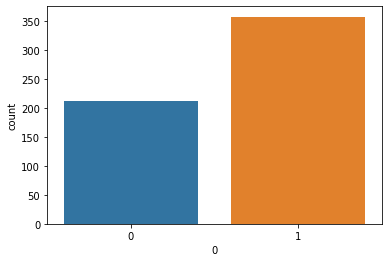

In [ ]:
sns.countplot(classe['0']);

In [ ]:
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = train_test_split(previsores,
                                                                                              classe,
                                                                                              test_size = 0.25)

In [ ]:
previsores_treinamento.shape

(426, 30)

In [ ]:
classe_treinamento.shape

(426, 1)

In [ ]:
previsores_teste.shape

(143, 30)

In [ ]:
classe_teste.shape

(143, 1)

## Etapa 3: Transformação dos dados para tensores


In [ ]:
type(previsores_treinamento)

pandas.core.frame.DataFrame

In [ ]:
type(np.array(previsores_treinamento))

numpy.ndarray

In [ ]:
previsores_treinamento = torch.tensor(np.array(previsores_treinamento), dtype=torch.float)
classe_treinamento = torch.tensor(np.array(classe_treinamento), dtype = torch.float)

In [ ]:
type(previsores_treinamento)

torch.Tensor

In [ ]:
type(classe_treinamento)

torch.Tensor

In [ ]:
dataset = torch.utils.data.TensorDataset(previsores_treinamento, classe_treinamento)

In [ ]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

## Etapa 4: Construção do modelo

In [ ]:
# 30 -> 16 -> 16 -> 1
# (entradas + saida) / 2 = (30 + 1) / 2 = 16
classificador = nn.Sequential(
    nn.Linear(in_features=30, out_features=16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

In [ ]:
classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optimizer = torch.optim.Adam(classificador.parameters(), lr=0.001, weight_decay=0.0001)

## Etapa 5: Treinamento do modelo

In [ ]:
for epoch in range(100):
  running_loss = 0.

  for data in train_loader:
    inputs, labels = data
    #print(inputs)
    #print('-----')
    #print(labels)
    optimizer.zero_grad()

    outputs = classificador(inputs) # classificador.forward(inputs)
    #print(outputs)
    loss = criterion(outputs, labels)
    #print(loss)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))

Época   1: perda 5.87815
Época   2: perda 4.87103
Época   3: perda 1.29733
Época   4: perda 1.24724
Época   5: perda 1.19310
Época   6: perda 1.18619
Época   7: perda 1.21091
Época   8: perda 1.14510
Época   9: perda 1.16327
Época  10: perda 1.12653
Época  11: perda 1.10449
Época  12: perda 1.08082
Época  13: perda 1.13301
Época  14: perda 1.06838
Época  15: perda 1.08918
Época  16: perda 1.09816
Época  17: perda 1.05278
Época  18: perda 1.06715
Época  19: perda 1.08669
Época  20: perda 1.10395
Época  21: perda 1.03446
Época  22: perda 1.02123
Época  23: perda 1.01870
Época  24: perda 1.02281
Época  25: perda 1.04290
Época  26: perda 1.05502
Época  27: perda 1.02884
Época  28: perda 1.01405
Época  29: perda 1.01658
Época  30: perda 1.03053
Época  31: perda 1.04432
Época  32: perda 1.06828
Época  33: perda 1.02021
Época  34: perda 1.05841
Época  35: perda 1.02615
Época  36: perda 1.03503
Época  37: perda 1.05089
Época  38: perda 0.99213
Época  39: perda 1.00877
Época  40: perda 1.02131


## Etapa 6: Visualização dos pesos

In [ ]:
# 30 -> 16 -> 16 -> 1
params = list(classificador.parameters())

In [ ]:
params

[Parameter containing:
 tensor([[-7.0918e-02, -2.4784e-01, -2.0447e-01,  4.4381e-02, -6.6166e-03,
           1.6759e-01,  2.1851e-02,  6.7733e-02, -1.5071e-01,  1.7265e-01,
           6.6839e-02,  5.0973e-02, -1.2273e-01, -3.3266e-02, -1.0328e-03,
          -3.3557e-01, -1.9727e-01, -2.2332e-01,  3.1529e-01,  4.0256e-03,
           1.2869e-01, -2.2151e-01, -6.1942e-02,  1.4110e-01, -1.6343e-02,
           1.2666e-01, -1.8419e-01,  5.8866e-02,  3.0419e-01,  1.9340e-01],
         [ 1.9249e-01,  1.7303e-01,  3.0585e-01,  1.0247e-01, -1.8210e-01,
          -1.0000e-01, -5.6555e-02, -1.8532e-01,  2.8427e-02,  1.3400e-01,
          -9.6749e-03, -6.1995e-02, -1.9660e-02,  1.9324e-01, -9.1747e-03,
          -1.9983e-02,  3.2470e-02,  1.9160e-01,  1.9907e-01, -1.9701e-02,
           8.7194e-02,  2.8786e-02,  2.0073e-01, -9.8248e-06,  1.6429e-01,
          -1.8595e-01, -2.4993e-01,  1.4592e-02, -9.9360e-02, -1.6902e-01],
         [ 1.2520e-03,  5.4250e-02, -1.8844e-01, -1.4577e-01,  1.8664e-06,


In [ ]:
# 30 -> 16 -> 16 -> 1
pesos0 = params[0]
pesos0.shape

torch.Size([16, 30])

In [ ]:
print(pesos0)

Parameter containing:
tensor([[-7.0918e-02, -2.4784e-01, -2.0447e-01,  4.4381e-02, -6.6166e-03,
          1.6759e-01,  2.1851e-02,  6.7733e-02, -1.5071e-01,  1.7265e-01,
          6.6839e-02,  5.0973e-02, -1.2273e-01, -3.3266e-02, -1.0328e-03,
         -3.3557e-01, -1.9727e-01, -2.2332e-01,  3.1529e-01,  4.0256e-03,
          1.2869e-01, -2.2151e-01, -6.1942e-02,  1.4110e-01, -1.6343e-02,
          1.2666e-01, -1.8419e-01,  5.8866e-02,  3.0419e-01,  1.9340e-01],
        [ 1.9249e-01,  1.7303e-01,  3.0585e-01,  1.0247e-01, -1.8210e-01,
         -1.0000e-01, -5.6555e-02, -1.8532e-01,  2.8427e-02,  1.3400e-01,
         -9.6749e-03, -6.1995e-02, -1.9660e-02,  1.9324e-01, -9.1747e-03,
         -1.9983e-02,  3.2470e-02,  1.9160e-01,  1.9907e-01, -1.9701e-02,
          8.7194e-02,  2.8786e-02,  2.0073e-01, -9.8248e-06,  1.6429e-01,
         -1.8595e-01, -2.4993e-01,  1.4592e-02, -9.9360e-02, -1.6902e-01],
        [ 1.2520e-03,  5.4250e-02, -1.8844e-01, -1.4577e-01,  1.8664e-06,
          7.88

In [ ]:
# 30 -> 16 -> 16 -> 1
bias0 = params[1]
bias0.shape

torch.Size([16])

In [ ]:
pesos1 = params[2]
pesos1.shape

torch.Size([16, 16])

In [ ]:
bias1 = params[3]
bias1.shape

torch.Size([16])

## Etapa 7: Avaliação do modelo

In [ ]:
classificador.eval()

Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
type(previsores_teste)

pandas.core.frame.DataFrame

In [ ]:
previsores_teste = torch.tensor(np.array(previsores_teste), dtype=torch.float)

In [ ]:
type(previsores_teste)

torch.Tensor

In [ ]:
previsoes = classificador.forward(previsores_teste)

In [ ]:
previsoes

tensor([[9.8956e-01],
        [1.0000e+00],
        [6.8384e-03],
        [9.7550e-01],
        [4.5597e-04],
        [9.5273e-01],
        [9.2892e-01],
        [9.9987e-01],
        [4.7272e-01],
        [8.5244e-01],
        [8.1941e-01],
        [9.9590e-01],
        [5.3159e-01],
        [9.9293e-01],
        [9.8545e-01],
        [7.5507e-01],
        [9.9268e-01],
        [1.0000e+00],
        [4.0525e-01],
        [9.9965e-01],
        [5.6184e-10],
        [1.3932e-02],
        [5.3859e-01],
        [1.0000e+00],
        [8.7227e-01],
        [6.2769e-03],
        [6.1371e-01],
        [1.0000e+00],
        [4.1813e-04],
        [9.9682e-01],
        [2.4819e-01],
        [9.9999e-01],
        [9.0120e-01],
        [9.6962e-01],
        [4.2945e-03],
        [9.9519e-01],
        [5.0036e-01],
        [9.9906e-01],
        [9.9997e-01],
        [1.2526e-04],
        [1.5756e-02],
        [8.3985e-01],
        [2.3040e-04],
        [3.1037e-01],
        [3.7558e-04],
        [6

In [ ]:
previsoes = np.array(previsoes > 0.5)
previsoes

array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [

In [ ]:
classe_teste

,0
333,1
273,1
201,0
178,1
85,0
...,...
230,0
282,0
535,0
436,1


In [ ]:
taxa_acerto = accuracy_score(classe_teste, previsoes)
taxa_acerto

0.9090909090909091

In [ ]:
matriz = confusion_matrix(classe_teste, previsoes)
matriz

array([[45,  9],
       [ 4, 85]])

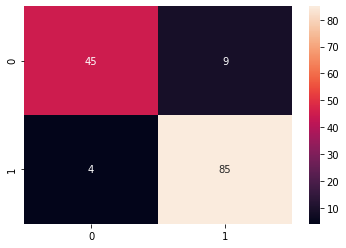

In [ ]:
sns.heatmap(matriz, annot=True);